In [30]:
# importacion de librerias
library(ggplot2)
library(dplyr)
library(readr)
library(caret)
library(rsample)
library(kknn)

Estas librerías son fundamentales para cumplir con los objetivos del trabajo, que incluyen desde la importación y manipulación de datos hasta la construcción, evaluación y visualización de modelos de machine learning.

La siguiente celda realiza la importación del conjunto de datos "Daegu_Real_Estate_v2data.csv" y se convierte en un data frame. Este conjunto de datos contiene información sobre transacciones de apartamentos en Daegu, Corea del Sur, entre agosto de 2007 y agosto de 2017.

In [2]:
base_daegu <- read_csv("Daegu_Real_Estate_v2data.csv")
base_daegu <- as.data.frame(base_daegu)

Rows: 5891 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): HallwayType, HeatingType, AptManageType, TimeToBusStop, TimeToSubw...
dbl (24): SalePrice, YearBuilt, YrSold, MonthSold, Size(sqf), Floor, N_Parki...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Resultado de la Importación

Filas: 5891
Columnas: 30

Las columnas incluyen una mezcla de variables categóricas (6) y numéricas (24). Algunas de las variables importantes son:

- `SalePrice`: Precio de venta de la vivienda (variable objetivo).
- `YearBuilt`: Año de construcción.
- `YrSold`: Año de venta.
- `MonthSold`: Mes de venta.
- `Size(sqf)`: Tamaño en pies cuadrados.
- `Floor`: Piso del apartamento.
- `N_Parkinglot(Ground)`, `N_Parkinglot(Basement)`: Número de estacionamientos en superficie y subterráneos.
- `TimeToBusStop`, `TimeToSubway`: Tiempo al paradero de bus y estación de metro.

Variables categóricas como `HallwayType`, `HeatingType`, y `AptManageType`.

En la siguiente celda se seleccionan las columnas categóricas del conjunto de datos y se calculan las frecuencias de las diferentes clases presentes en cada una de estas variables. Esto es crucial para entender la distribución de las categorías y cómo están representadas en el conjunto de datos.

In [3]:
#selecciono las columnas categoricas
col_cate <- c("HallwayType", "HeatingType", "AptManageType",
              "TimeToBusStop", "TimeToSubway", "SubwayStation")
valores_por_clase <- lapply(base_daegu[col_cate], table)
valores_por_clase

$HallwayType

corridor    mixed terraced 
     637     1690     3564 

$HeatingType

   central_heating individual_heating 
               300               5591 

$AptManageType

management_in_trust     self_management 
               5542                 349 

$TimeToBusStop

     0~5min 10min~15min  5min~10min 
       4509          55        1327 

$TimeToSubway

            0-5min        10min~15min        15min~20min         5min~10min 
              2759                806                953               1135 
no_bus_stop_nearby 
               238 

$SubwayStation

              Bangoge            Banwoldang      Chil-sung-market 
                  737                   748                   115 
                Daegu Kyungbuk_uni_hospital             Myung-duk 
                   85                  1644                  1507 
     no_subway_nearby               Sin-nam 
                  404                   651 


La siguiente celda realiza la conversión de las variables categóricas a variables dummies, un paso esencial para el preprocesamiento de datos antes de aplicar el algoritmo k-NN de regresión.

In [4]:
# Defino el objeto con las variables categóricas a convertir
dv <- dummyVars("~ .", data = base_daegu[, col_cate], fullRank = TRUE)
# creo el diseño de la matriz
design_matrix <- data.frame(predict(dv, newdata = base_daegu[, col_cate]))
# veo el resultado
head(design_matrix)

,HallwayTypemixed,HallwayTypeterraced,HeatingTypeindividual_heating,AptManageTypeself_management,TimeToBusStop10min.15min,TimeToBusStop5min.10min,TimeToSubway10min.15min,TimeToSubway15min.20min,TimeToSubway5min.10min,TimeToSubwayno_bus_stop_nearby,SubwayStationBanwoldang,SubwayStationChil.sung.market,SubwayStationDaegu,SubwayStationKyungbuk_uni_hospital,SubwayStationMyung.duk,SubwayStationno_subway_nearby,SubwayStationSin.nam
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0
2,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
6,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0


1. Definición del Objeto `dummyVars`:

- Se utiliza la función `dummyVars` del paquete `caret` para definir cómo se convertirán las variables categóricas.
- La fórmula `"~ ."` indica que todas las columnas de `base_daegu[, col_cate]` (osea solo las columnas categoricas) serán transformadas.
- El argumento `fullRank = TRUE` asegura que, para cada variable categórica con `N` clases, se generen `N-1` columnas dummy, evitando la multicolinealidad.

2. Creación de la Matriz de Diseño:

- Se usa la función `predict` para aplicar la transformación definida en `dv` a los datos categóricos originales.
- El resultado es una matriz de diseño (`design_matrix`) con las variables categóricas convertidas a variables dummies.

3. Visualización del Resultado:

- `head(design_matrix)` muestra las primeras filas de la matriz de diseño resultante para verificar la conversión.

Propósito

La conversión de variables categóricas a variables dummies es necesaria porque los algoritmos de machine learning, como k-NN, no pueden manejar variables categóricas directamente. Las variables categóricas deben ser transformadas en un formato numérico adecuado para que el algoritmo pueda calcular las distancias correctamente.

Conversión de Variables Categóricas

Razonamiento:

- Las variables categóricas contienen clases que representan diferentes estados o categorías. Para que estas variables puedan ser utilizadas en el cálculo de distancias, deben ser convertidas en una representación numérica.
- La técnica de variables dummies asigna una columna binaria (0 o 1) para cada clase de la variable categórica, lo que permite representar la presencia o ausencia de una clase.

N Clases a N-1 Columnas:

- Si una variable categórica tiene N clases, se generan N-1 columnas dummies. Esto se hace para evitar la multicolinealidad, que ocurre cuando las variables predictoras están altamente correlacionadas entre sí.
- Por ejemplo, si una variable tiene tres clases (A, B, C), se crean dos columnas: una para A y otra para B. La clase C puede ser inferida cuando ambas columnas tienen el valor 0.
- Este enfoque garantiza que la información sobre la variable categórica esté completamente representada sin redundancias.

En la siguiente celda se realizan dos operaciones clave para preparar el conjunto de datos para el análisis posterior con el algoritmo k-NN, que son la eliminación de las columnas originales (las categoricas) y la union de la matriz de diseño con la base de datos original

In [5]:
# elimino las columnas originales
base_daegu <- base_daegu[, -which(names(base_daegu) %in% col_cate)]
# uno las columnas de la matriz de diseño
base_daegu <- cbind(base_daegu, design_matrix)
head(base_daegu)

,SalePrice,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_APT,N_manager,⋯,TimeToSubway15min.20min,TimeToSubway5min.10min,TimeToSubwayno_bus_stop_nearby,SubwayStationBanwoldang,SubwayStationChil.sung.market,SubwayStationDaegu,SubwayStationKyungbuk_uni_hospital,SubwayStationMyung.duk,SubwayStationno_subway_nearby,SubwayStationSin.nam
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,141592,2006,2007,8,814,3,111,184,3,3,⋯,0,0,0,0,0,0,1,0,0,0
2,51327,1985,2007,8,587,8,80,76,1,2,⋯,0,1,0,0,0,1,0,0,0,0
3,48672,1985,2007,8,587,6,80,76,1,2,⋯,0,1,0,0,0,1,0,0,0,0
4,380530,2006,2007,8,2056,8,249,536,6,5,⋯,0,0,0,0,0,0,0,0,0,1
5,221238,1993,2007,8,1761,3,523,536,8,8,⋯,1,0,0,0,0,0,0,1,0,0
6,35840,1992,2007,8,355,5,200,0,3,5,⋯,0,0,0,0,0,0,0,1,0,0


El objetivo de este paso es integrar las variables dummies con las variables numéricas originales en un solo data frame. Esto es crucial para asegurarse de que el conjunto de datos esté preparado para la aplicación del algoritmo k-NN, que requiere que todas las variables sean numéricas.

En las 2 próximas celdas se definen dos funciones esenciales para el preprocesamiento de los datos: una para normalizar las variables numéricas y otra para desnormalizarlas. Estas funciones son fundamentales para el uso de algoritmos de machine learning, como k-NN, que son sensibles a las escalas de las variables.

In [6]:
# Función de normalización
normalizar <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}

La normalización reescala los valores de una variable para que estén dentro de un rango específico [0, 1]. Esto es importante para que todas las variables contribuyan de manera equitativa en el cálculo de distancias, evitando que las variables con rangos más amplios dominen las distancias.

In [7]:
# Función de desnormalización
desnormalizar <- function(x, min_val, max_val) {
  return(x * (max_val - min_val) + min_val)
}

La desnormalización convierte los valores normalizados de regreso a su escala original. Esto es útil para interpretar los resultados del modelo en el contexto original de los datos.

El algoritmo k-NN es sensible a las escalas de las variables porque se basa en métricas de distancia para encontrar los vecinos más cercanos. Si las variables no están normalizadas, aquellas con rangos más amplios tendrán una influencia desproporcionada en las distancias calculadas, lo que puede llevar a un rendimiento subóptimo del modelo.

La siguiente celda almacena los valores mínimos y máximos originales de todas las columnas del conjunto de datos base_daegu. Esta información es crucial para la desnormalización de los datos después de que se hayan realizado las predicciones con el modelo k-NN.

In [8]:
# Guardar los valores mínimos y máximos originales de todas las columnas
min_vals <- sapply(base_daegu, min)
max_vals <- sapply(base_daegu, max)

Después de que normalizar y que el modelo k-NN haga sus predicciones, es necesario convertir estos valores normalizados de regreso a su escala original para interpretarlos en la escala original de los datos.

En la siguiente celda se aplica la normalización a todas las columnas del conjunto de datos `base_daegu`. Dado que las variables categóricas ya han sido convertidas a variables dummies (y, por lo tanto, ya están en formato binario 0 y 1), esta operación efectivamente normaliza solo las variables numéricas.

In [9]:
# Normalizar todas las columnas
# dado que las categoricas ya estan normalizadas, al normalizar
# todas las columnas, solo se normalizaran las numericas y las
# categoricas se mantendran igual
base_daegu <- as.data.frame(lapply(base_daegu, normalizar))
# Verificar la normalización
head(base_daegu)

,SalePrice,YearBuilt,YrSold,MonthSold,Size.sqf.,Floor,N_Parkinglot.Ground.,N_Parkinglot.Basement.,N_APT,N_manager,⋯,TimeToSubway15min.20min,TimeToSubway5min.10min,TimeToSubwayno_bus_stop_nearby,SubwayStationBanwoldang,SubwayStationChil.sung.market,SubwayStationDaegu,SubwayStationKyungbuk_uni_hospital,SubwayStationMyung.duk,SubwayStationno_subway_nearby,SubwayStationSin.nam
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.196799115,0.7567568,0,0.6363636,0.30835604,0.04761905,0.1556802,0.13928842,0.1666667,0.15384615,⋯,0,0,0,0,0,0,1,0,0,0
2,0.033599893,0.1891892,0,0.6363636,0.20526794,0.16666667,0.1122020,0.05753217,0.0000000,0.07692308,⋯,0,1,0,0,0,1,0,0,0,0
3,0.028799650,0.1891892,0,0.6363636,0.20526794,0.11904762,0.1122020,0.05753217,0.0000000,0.07692308,⋯,0,1,0,0,0,1,0,0,0,0
4,0.628799288,0.7567568,0,0.6363636,0.87238874,0.16666667,0.3492286,0.40575322,0.4166667,0.30769231,⋯,0,0,0,0,0,0,0,0,0,1
5,0.340799173,0.4054054,0,0.6363636,0.73841962,0.04761905,0.7335203,0.40575322,0.5833333,0.53846154,⋯,1,0,0,0,0,0,0,1,0,0
6,0.005599379,0.3783784,0,0.6363636,0.09990917,0.09523810,0.2805049,0.00000000,0.1666667,0.30769231,⋯,0,0,0,0,0,0,0,1,0,0


Normalizar las variables es esencial en k-NN porque:

- Consistencia: Asegura que todas las variables contribuyan de manera similar en el cálculo de distancias.
- Evita el Dominio de Variables: Previene que las variables con rangos mayores dominen las distancias y, por lo tanto, el resultado del modelo.

Las siguiente celda se verifica que todas las columnas del conjunto de datos base_daegu hayan sido normalizadas correctamente. 

In [10]:
# Quiero verificar que todos mis columnas tengan como mínimo 0 y como máximo 1
summary(base_daegu)[c(1, 6), ]

   SalePrice        YearBuilt          YrSold         MonthSold     
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
   Size.sqf.          Floor        N_Parkinglot.Ground. N_Parkinglot.Basement.
 Min.   :0.0000   Min.   :0.0000   Min.   :0.00000      Min.   :0.0000        
 Max.   :1.0000   Max.   :1.0000   Max.   :1.00000      Max.   :1.0000        
     N_APT          N_manager       N_elevators    
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
 N_FacilitiesNearBy.PublicOffice. N_FacilitiesNearBy.Hospital.
 Min.   :0.0000                   Min.   :0.000               
 Max.   :1.0000                   Max.   :1.000               
 N_FacilitiesNearBy.Dpartmentstore. N_FacilitiesNearBy.Mall.
 Min.   :0.0000                     Min.   :0.0000          
 Max.   :1.0000                     Max.   :1.0000          
 N_FacilitiesNearBy.ETC. N_F

En la siguiente celda se realiza la división del conjunto de datos en conjuntos de entrenamiento y prueba, asegurando que la distribución de la variable objetivo SalePrice se mantenga consistente en ambos conjuntos mediante estratificación. Se utiliza una semilla aleatoria para garantizar la reproducibilidad de los resultados.

In [11]:
set.seed(123) #inserto semilla
# Divido el conjunto de datos en entrenamiento y prueba
# donde el 70% de los datos son para entrenamiento y el 30% para prueba
# y estratifico por la variable objetivo SalePrice
particiones <- initial_split(base_daegu, prop = 0.7, strata = "SalePrice")
# Guardo los datos de entrenamiento y prueba
# en dos variables diferentes
entrenamiento <- training(particiones)
prueba <- testing(particiones)

Porqué del 70%-30%

1. **Suficiente Cantidad de Datos para Entrenamiento**:
   - Usar el 70% de los datos para el entrenamiento asegura que el modelo tenga acceso a una cantidad suficiente de datos para aprender las características y patrones del conjunto de datos. Esto es esencial para construir un modelo robusto y reducir el riesgo de subajuste.

2. **Evaluación Representativa**:
   - Al reservar el 30% de los datos para el conjunto de prueba, se asegura una evaluación representativa del rendimiento del modelo. Este conjunto debe ser lo suficientemente grande para proporcionar una evaluación precisa y confiable del modelo en datos no vistos.

3. **Prácticas Comunes**:
   - La proporción de 70%-30% es una práctica común en machine learning, proporcionando un buen balance entre tener suficientes datos para el entrenamiento y una cantidad adecuada para la evaluación del modelo.

Subajuste y Sobreajuste

Subajuste

- **Definición**: Ocurre cuando un modelo es demasiado simple para capturar la estructura subyacente de los datos. Un modelo con subajuste tendrá un rendimiento pobre tanto en el conjunto de entrenamiento como en el de prueba.
- **Prevención**: Utilizar una proporción adecuada de datos de entrenamiento ayuda a mitigar el subajuste. Con el 70% de los datos para el entrenamiento, el modelo tiene suficiente información para aprender patrones complejos sin ser demasiado simple.

Sobreajuste

- **Definición**: Ocurre cuando un modelo es demasiado complejo y se ajusta demasiado a los datos de entrenamiento, capturando también el ruido y las peculiaridades específicas de estos datos. Un modelo con sobreajuste tendrá un rendimiento excelente en el conjunto de entrenamiento pero pobre en el conjunto de prueba.
- **Prevención**: Reservar el 30% de los datos para el conjunto de prueba permite evaluar cómo generaliza el modelo a datos nuevos. Si el modelo tiene un rendimiento significativamente peor en el conjunto de prueba comparado con el conjunto de entrenamiento, esto indica un posible sobreajuste.

Estratificación por `SalePrice`

- **Motivación**: La estratificación por la variable objetivo `SalePrice` asegura que la distribución de los precios de venta sea representativa en ambos conjuntos (entrenamiento y prueba). Esto es crucial para evitar sesgos y asegurar que el modelo sea evaluado de manera justa en una muestra que refleja la población original.

La proporción 70%-30% para la división del conjunto de datos se elige para equilibrar adecuadamente la cantidad de datos disponibles para el entrenamiento y la evaluación, ayudando a prevenir tanto el subajuste como el sobreajuste. La estratificación por `SalePrice` asegura que ambos conjuntos tengan distribuciones representativas, mejorando la robustez y la precisión de la evaluación del modelo.

Importancia de la Estratificación

- `Consistencia en la Distribución`: La estratificación asegura que la variable objetivo tenga una distribución similar en ambos conjuntos, lo cual es importante para evitar sesgos en el modelo.
- `Mejor Evaluación del Modelo`: Garantiza que el modelo sea evaluado en un conjunto de prueba representativo, proporcionando una medida más precisa de su rendimiento en datos no vistos.

En la siguiente celda se genera un gráfico de densidad para comparar la distribución de la variable objetivo SalePrice en el conjunto de datos original, de entrenamiento y de prueba. Esto es importante para asegurarse de que la estratificación haya mantenido la distribución de la variable objetivo de manera consistente en ambos subconjuntos.

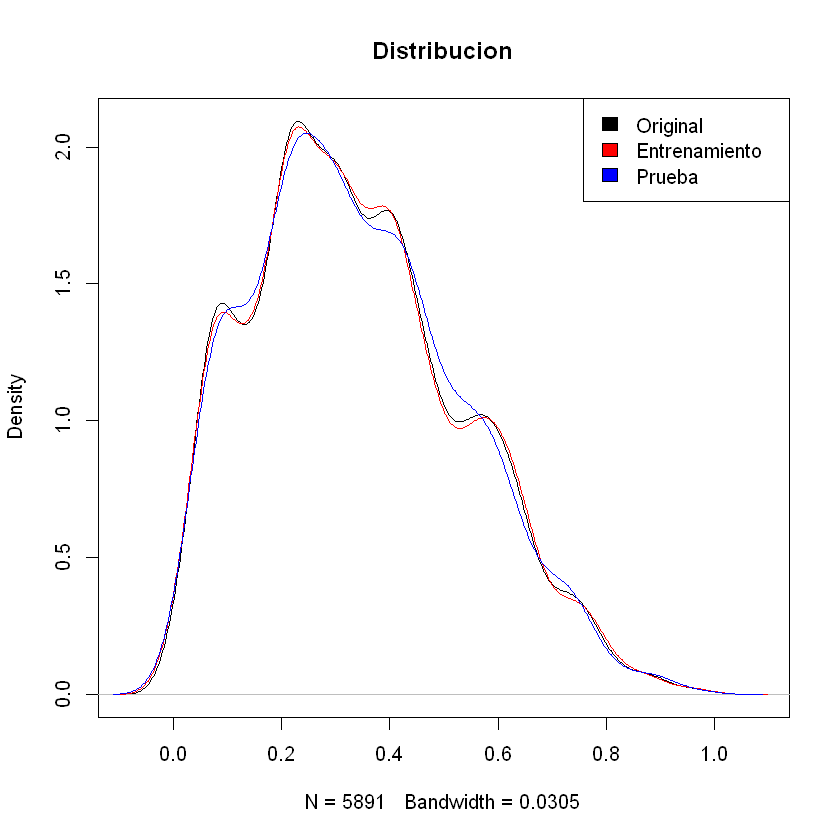

In [12]:
# quiero comprobar la distribución de la variable objetivo
# en los conjuntos original, de entrenamiento y de prueba
# con un gráfico de densidad sin ocupar ggplot
plot(density(base_daegu$SalePrice), col = "black", main = "Distribucion")
lines(density(entrenamiento$SalePrice), col = "red")
lines(density(prueba$SalePrice), col = "blue")
legend("topright", c("Original", "Entrenamiento", "Prueba"),
       fill = c("black", "red", "blue"))

Líneas de Densidad:

- Negro: Distribución de SalePrice en el conjunto de datos original.
- Rojo: Distribución de SalePrice en el conjunto de entrenamiento.
- Azul: Distribución de SalePrice en el conjunto de prueba.

Observaciones:

- Las tres líneas de densidad (negra, roja y azul) se superponen en gran medida, indicando que las distribuciones de SalePrice en el conjunto original, de entrenamiento y de prueba son muy similares.
- Esto confirma que la estratificación ha funcionado correctamente, manteniendo una distribución representativa de la variable objetivo en ambos conjuntos.

Importancia

Mantener la consistencia en la distribución de la variable objetivo entre los conjuntos de entrenamiento y de prueba es crucial para:

- Evaluación Justa del Modelo: Asegura que el modelo sea evaluado en un conjunto de prueba que es representativo de los datos en general.
- Evitar Sesgos: Previene sesgos en la evaluación del rendimiento del modelo, proporcionando una medida precisa de su capacidad para generalizar a datos no vistos.

En la siguiente celda se aplica el modelo k-NN de regresión utilizando k = 1 y se obtienen las predicciones para el conjunto de prueba. 

In [13]:
#Aplicacion del modelo knn de regresion con k=1
# y obtencion de las predicciones
knn <- knnreg(SalePrice ~ ., entrenamiento, k = 1)
knn_pred <- predict(knn, newdata = prueba[, colnames(prueba) != "SalePrice"])
knn_pred <- as.vector(knn_pred)
head(knn_pred)

[1] 0.033599893 0.268159111 0.005599379 0.108800084 0.628799288 0.171199627

- Después de entrenar el modelo KNN (K-Nearest Neighbors) en la línea 1, el modelo está listo para hacer predicciones. El entrenamiento se hizo con el conjunto de datos entrenamiento, usando SalePrice como la variable objetivo y todas las demás variables como predictores.
Objetivo:

- El objetivo de la línea 2 es usar el modelo entrenado (knn) para hacer predicciones sobre un conjunto de datos nuevo (el conjunto de prueba prueba).

Proceso:

- `predict(knn, newdata = prueba[, colnames(prueba) != "SalePrice"])`:
- `predict(knn, newdata = ...)`: Esta función toma el modelo entrenado (knn) y hace predicciones usando un nuevo conjunto de datos (newdata).
- `prueba[, colnames(prueba) != "SalePrice"]`: Aquí se especifica que se deben usar todas las columnas del conjunto de prueba prueba, excepto la columna `SalePrice`. Esto se hace porque SalePrice es la variable que queremos predecir, no una de las variables predictoras.
- El modelo utiliza los valores de las variables predictoras en el conjunto de prueba para generar predicciones de `SalePrice` basado en el aprendizaje que hizo el algoritmo en la línea 1. En otras palabras, para cada fila en prueba, el modelo toma los valores de todas las columnas predictoras y genera un valor predicho para `SalePrice`.
Resultado:

- El resultado de esta función es un vector de predicciones `(knn_pred)`. Cada valor en este vector corresponde a una predicción de `SalePrice` para una fila del conjunto de prueba. Estas predicciones son los valores estimados de `SalePrice` basados en los valores de las variables predictoras en prueba.

- La línea 2 utiliza el modelo KNN entrenado para predecir los valores de `SalePrice` en el conjunto de prueba, basado en el aprendizaje que hizo el algoritmo en la línea 1. Para cada fila en el conjunto de prueba, el modelo toma los valores de todas las variables predictoras (excepto `SalePrice`) y genera una predicción de `SalePrice`. Estas predicciones son los valores de `knn_pred`.

Respecto a Valor k = 1:

- Utiliza el vecino más cercano para hacer predicciones.
- Es propenso a sobreajustar los datos de entrenamiento, capturando ruido y peculiaridades específicas del conjunto de datos de entrenamiento.
- Puede proporcionar una evaluación inicial del rendimiento del modelo, pero generalmente no es el valor óptimo de k para la mayoría de los problemas. (lo que se demostrará mas adelante)

En la siguiente celda se desnormalizan las predicciones del modelo k-NN para devolver los valores a su escala original. Este paso es crucial para interpretar las predicciones en el contexto original de los datos, específicamente para la variable objetivo SalePrice.

In [14]:
#Desnormalizo las predicciones para devolverlas a la escala original
#osea desnormalizo los valores de SalePrice de las predicciones
knn_pred <- desnormalizar(knn_pred, min_vals["SalePrice"],
                          max_vals["SalePrice"])
head(knn_pred)

[1]  51327 181061  35840  92920 380530 127433

Estos valores ahora están en la escala original de `SalePrice`, lo que permite una interpretación directa y una comparación con los valores reales en el conjunto de prueba.

La desnormalización de las predicciones es esencial para:

- Interpretación: Permitir la interpretación de las predicciones en el contexto original de los datos.
- Comparación: Facilitar la comparación directa entre las predicciones y los valores reales de SalePrice.

En la siguiente celda se desnormalizan los valores de SalePrice en el conjunto de prueba. Esto permite comparar las predicciones desnormalizadas con los valores reales de SalePrice en su escala original.

In [16]:
#desnormalizo los valores de SalePrice en el conjunto de prueba
precio_prueba <- desnormalizar(prueba$SalePrice, min_vals["SalePrice"],
                               max_vals["SalePrice"])
head(precio_prueba)

[1]  48672 200884  38053  92035 292035 138053

Desnormalizar SalePrice en el conjunto de prueba es crucial para:

- Comparabilidad: Permitir la comparación directa entre las predicciones desnormalizadas y los valores reales de `SalePrice`.
- Evaluación del Modelo: Facilitar la evaluación del rendimiento del modelo utilizando métricas.

En las siguientes 2 celdas se definen y calculan varias métricas de evaluación del modelo k-NN utilizando las predicciones desnormalizadas y los valores reales de `SalePrice` en el conjunto de prueba. Estas métricas permiten evaluar la precisión y efectividad del modelo.

In [17]:
# Funciones de Métricas de Evaluación del Modelo
mae <- function(actual, predicted) {
  mean(abs(actual - predicted))
}

rmse <- function(actual, predicted) {
  sqrt(mean((actual - predicted)^2))
}

metrics <- function(actual, predicted) {
  cat("cor  =", cor(actual, predicted),
      "\nMAE  =", mae(actual, predicted),
      "\nRMSE =", rmse(actual, predicted))
}

In [18]:
#Veo las metricas de evaluacion
metrics(precio_prueba, knn_pred)

cor  = 0.9615033 
MAE  = 18413.52 
RMSE = 29335.16

Resultados de las Métricas

- Correlación (cor): Indica una fuerte correlación positiva entre los valores predichos y los valores reales. Una correlación de 0.9615 sugiere que las predicciones del modelo k-NN están fuertemente alineadas con los valores reales de `SalePrice`.

- MAE (Mean Absolute Error): Representa el error absoluto medio en las predicciones. Un valor más bajo indica un modelo más preciso. Un MAE de 18413.52 indica que, en promedio, las predicciones del modelo k-NN están a 18413.52 unidades monetarias de los valores reales.

- RMSE (Root Mean Squared Error): Representa la raíz del error cuadrático medio. Un valor más bajo indica un modelo más preciso. Un RMSE de 29335.16 proporciona una medida de la desviación cuadrática media de las predicciones respecto a los valores reales. Valores más bajos de RMSE son preferibles ya que indican menor error.

Dado que el paquete knnreg ofrece muy poca configuración, y el objetivo es minimizar el RMSE, algo que es conseguible configurando parametros e hiperparametro, se opta por ocupar paquete kknn, para revisar si es que se puede minimizar más la metrica RMSE.

### k-nn con paquete kknn

En la siguiente celda se aplica el modelo k-NN de regresión utilizando el paquete kknn en lugar de knnreg. El objetivo es aprovechar las capacidades avanzadas de configuración y optimización del paquete kknn para minimizar la métrica RMSE.

In [19]:
set.seed(12345)
# realizo la prediccion con el modelo knn de regresionm con k=1
# y con el metodo de kernel optimo, distancia euclidiana p = 2
knn <- kknn(SalePrice ~ ., entrenamiento, prueba, distance = 2, k = 1)
knn_pred <- knn$fitted.values
head(knn_pred)

[1] 0.033599893 0.268159111 0.005599379 0.108800084 0.628799288 0.171199627

Paso a Paso del Proceso

Configuración de la Semilla:

- `set.seed(12345)`: Establece una semilla para garantizar la reproducibilidad de los resultados.

Aplicación del Modelo k-NN con kknn:

- `knn <- kknn(SalePrice ~ ., entrenamiento, prueba, distance = 2, k = 1)`:
- Utiliza la función `kknn` para crear un modelo k-NN de regresión.
- `SalePrice ~ .` indica que `SalePrice` es la variable objetivo y todas las demás columnas son predictores.
- `distance = 2` especifica el uso de la distancia euclidiana.
- `k = 1` indica que se utiliza el vecino más cercano.

Obtención de las Predicciones:

- `knn_pred <- knn$fitted.values`: Extrae los valores predichos del modelo k-NN.
- `head(knn_pred)`: Muestra las primeras seis predicciones obtenidas.

El paquete `knnreg` ofrece opciones limitadas para configurar y optimizar el modelo k-NN. En contraste, kknn proporciona mayor flexibilidad y capacidad de ajuste, permitiendo configuraciones avanzadas como:

- `Métodos de Kernel`: Diferentes métodos de kernel pueden influir en la suavidad de las predicciones.
- `Distancias Personalizables`: Permite especificar diferentes métricas de distancia (e.g., euclidiana, Manhattan).
- `Optimización de Hiperparámetros`: Facilita la búsqueda de valores óptimos para los hiperparámetros, como el número de vecinos k.

En la siguiente celda se desnormalizan las predicciones obtenidas del modelo k-NN para devolver los valores a su escala original de SalePrice. Este paso es crucial para interpretar las predicciones en la escala original de los datos.

In [20]:
#Desnormalizo las predicciones para devolverlas a la escala original
knn_pred <- desnormalizar(knn_pred, min_vals["SalePrice"],
                          max_vals["SalePrice"])
head(knn_pred)

[1]  51327 181061  35840  92920 380530 127433

Los valores ahora están en la escala original de SalePrice, lo que permite una interpretación directa y una comparación con los valores reales en el conjunto de prueba.

La desnormalización de las predicciones es esencial para:

- Interpretación: Permitir la interpretación de las predicciones en el contexto original de los datos.
- Comparación: Facilitar la comparación directa entre las predicciones y los valores reales de SalePrice.

En la siguiente celda se desnormalizan los valores de SalePrice en el conjunto de prueba. Esto permite comparar las predicciones desnormalizadas con los valores reales de SalePrice en su escala original.

In [21]:
#desnormalizo los valores de SalePrice en el conjunto de prueba
precio_prueba <- desnormalizar(prueba$SalePrice, min_vals["SalePrice"],
                               max_vals["SalePrice"])
head(precio_prueba)

[1]  48672 200884  38053  92035 292035 138053

Los valores están ahora en la escala original de SalePrice, lo que facilita la interpretación y comparación con las predicciones del modelo.

Desnormalizar SalePrice en el conjunto de prueba es crucial para:

- Comparabilidad: Permitir la comparación directa entre las predicciones desnormalizadas y los valores reales de SalePrice.
- Evaluación del Modelo: Facilitar la evaluación del rendimiento del modelo utilizando métricas. 

En las siguientes celda se ocupa la variable metrics, ya definida y explicada anteriormente, pero en esta oportunidad para calcular varias métricas de evaluación del modelo k-NN utilizando el paquete kknn ocupando las predicciones desnormalizadas y los valores reales de `SalePrice` en el conjunto de prueba.

In [22]:
#Veo las metricas de evaluacion
metrics(precio_prueba, knn_pred)

cor  = 0.962854 
MAE  = 17643.97 
RMSE = 28791.39

Análisis de los Resultados

Correlación

- **`knnreg`**: 0.9615033
- **`kknn`**: 0.962854
- **Interpretación**: Ambos modelos muestran una correlación alta entre las predicciones y los valores reales, indicando que ambos modelos capturan bien la relación entre las variables predictoras y la variable objetivo. Sin embargo, el modelo `kknn` tiene una correlación ligeramente superior, sugiriendo una mejor alineación entre las predicciones y los valores reales.

MAE (Mean Absolute Error)

- **`knnreg`**: 18413.52
- **`kknn`**: 17643.97
- **Interpretación**: El MAE más bajo del modelo `kknn` indica que, en promedio, las predicciones están más cerca de los valores reales en comparación con el modelo `knnreg`. Esto sugiere una mejora en la precisión de las predicciones al usar `kknn`.

RMSE (Root Mean Squared Error)

- **`knnreg`**: 29335.16
- **`kknn`**: 28791.39
- **Interpretación**: El RMSE más bajo del modelo `kknn` indica que las predicciones tienen una desviación cuadrática media menor respecto a los valores reales en comparación con el modelo `knnreg`. Esto sugiere que el modelo `kknn` maneja mejor los errores grandes y proporciona predicciones más precisas.

Ventajas de Usar `kknn` Sobre `knnreg`

1. **Configuración Avanzada**:
   - **Número de Vecinos**: Ambos paquetes permiten configurar el número de vecinos (k), pero `kknn` ofrece configuraciones adicionales.
   - **Métricas de Distancia**: `kknn` permite elegir entre diferentes métricas de distancia (Euclidiana, Manhattan, Minkowski), proporcionando flexibilidad para seleccionar la mejor métrica para los datos específicos.
   - **Métodos de Kernel**: `kknn` incluye opciones de kernel que pueden mejorar la suavidad y precisión de las predicciones.

2. **Mejor Rendimiento**:
   - **Menor MAE y RMSE**: Las métricas más bajas obtenidas con `kknn` indican que este paquete puede producir modelos más precisos, lo cual es crucial cuando el objetivo es minimizar el RMSE.
   - **Mejor Correlación**: La correlación ligeramente superior sugiere que las predicciones de `kknn` están mejor alineadas con los valores reales.

El uso del paquete `kknn` ha demostrado una mejora en el rendimiento del modelo k-NN en comparación con `knnreg`. Por ende lo siguiente será encontrar los mejores parametros de kknn para minimizar aún más el RMSE.


En la siguiente celda se configura el control de entrenamiento utilizando el método de bootstrap y se define una cuadrícula de hiperparámetros para explorar durante el proceso de ajuste del modelo. El objetivo es encontrar la combinación de hiperparámetros que minimice el RMSE.

In [23]:
# Configuración de control de entrenamiento para bootstrap
boot <- trainControl(method = "boot", number = 1)
# Parámetros
hyper_grid <- expand.grid(kmax = seq(1, 20, 2),
                          distance = seq(1, 3, 1),
                          kernel = c("optimal", "gaussian", "triangular"))

Paso a Paso del Proceso

1. Configuración de Control de Entrenamiento para Bootstrap:

- `boot <- trainControl(method = "boot", number = 1)`:
- `method = "boot"`: Especifica que se utilizará el método de bootstrap para el remuestreo.
- `number = 1`: Indica que se realizará un solo ciclo de bootstrap en cada iteración del ajuste de hiperparámetros. Esto se puede ajustar según la necesidad para realizar más iteraciones de bootstrap.

2. Definición de la Cuadrícula de Hiperparámetros:

- `hyper_grid <- expand.grid(kmax = seq(1, 20, 2), distance = seq(1, 3, 1), kernel = c("optimal", "gaussian", "triangular"))`:
- `kmax = seq(1, 20, 2)`: Explora valores impares de k desde 1 hasta 20.
- `distance = seq(1, 3, 1)`: Explora tres métricas de distancia diferentes: 1 (Manhattan), 2 (Euclidiana), y 3 (Minkowski).
- `kernel = c("optimal", "gaussian", "triangular")`: Explora tres métodos de kernel diferentes: óptimo, gaussiano y triangular.

Selección de Valores de k

Número de Vecinos (kmax):

- Rango de 1 a 20: Este rango proporciona un buen equilibrio entre explorar modelos muy simples (k = 1) y modelos más complejos (k = 20).
- Incremento de 2 en 2: Los valores impares de k se utilizan para evitar empates en la clasificación, lo cual es particularmente relevante en problemas de clasificación. Aunque en regresión, el uso de valores impares ayuda a mantener consistencia y evita situaciones en las que múltiples vecinos podrían influir de manera igualitaria pero contradictoria en la predicción.
- Número Impar: Para regresión, el uso de números impares también facilita una mejor distribución de los vecinos considerados y evita posibles sesgos introducidos por divisiones iguales.

Importancia

- Método de Bootstrap: El bootstrap es un método de remuestreo que permite evaluar la estabilidad y la variabilidad del modelo, proporcionando una estimación más robusta del rendimiento del modelo.
- Exploración de Hiperparámetros: La definición de una cuadrícula de hiperparámetros permite explorar sistemáticamente diferentes combinaciones de parámetros para encontrar la mejor configuración que minimice el RMSE. La capacidad de ajustar múltiples parámetros simultáneamente (k, distancia y kernel) es una ventaja significativa del paquete kknn.

El objetivo es utilizar el control de entrenamiento y la cuadrícula de hiperparámetros para ajustar el modelo k-NN de manera óptima, encontrando la combinación de parámetros que minimice el RMSE y mejore la precisión del modelo.

**Nota importante**: El modificar el numero de bootstraps trae consigo una enorme carga computacional, a modo de ejemplo, lo probe con 3 numeros distintos, donde obtuve los siguientes tiempos de ejecucion:

- 1 bootstrap --> 3 min 50
- 5 bootstraps --> 19 min 40
- 20 bootstraps --> 1 hr 16 min

Por lo que para efectos de velocidad de ejecución de este modelo, preferí dejarlo con 1 bootstrap.

En la siguiente celda se entrena un modelo k-NN utilizando el paquete kknn con una grilla de hiperparámetros definida previamente. El objetivo es encontrar la combinación óptima de hiperparámetros que minimice el RMSE.

In [24]:
# Entrenamiento
set.seed(12345)
knn_fit <- train(SalePrice ~ ., data = entrenamiento, method = "kknn",
                 metric = "RMSE", trControl = boot, tuneGrid = hyper_grid)

knn_fit

k-Nearest Neighbors 

4121 samples
  40 predictor

No pre-processing
Resampling: Bootstrapped (1 reps) 
Summary of sample sizes: 4121 
Resampling results across tuning parameters:

  kmax  distance  kernel      RMSE        Rsquared   MAE       
   1    1         optimal     0.05302130  0.9223631  0.03352027
   1    1         gaussian    0.05302130  0.9223631  0.03352027
   1    1         triangular  0.05302130  0.9223631  0.03352027
   1    2         optimal     0.05392793  0.9191230  0.03453864
   1    2         gaussian    0.05392793  0.9191230  0.03453864
   1    2         triangular  0.05392793  0.9191230  0.03453864
   1    3         optimal     0.05283243  0.9222793  0.03400897
   1    3         gaussian    0.05283243  0.9222793  0.03400897
   1    3         triangular  0.05283243  0.9222793  0.03400897
   3    1         optimal     0.05038349  0.9294120  0.03192316
   3    1         gaussian    0.05302130  0.9223631  0.03352027
   3    1         triangular  0.04817849  0.9351485

El modelo se ajustó utilizando bootstrap y se evaluó a través de varias combinaciones de hiperparámetros (kmax, distancia y kernel).

El uso del paquete kknn con una cuadrícula de hiperparámetros y el método de bootstrap ha permitido encontrar una combinación óptima de parámetros que mejora significativamente las métricas de rendimiento del modelo k-NN. Esto demuestra la importancia de la optimización de hiperparámetros para mejorar la precisión y robustez de los modelos de machine learning.

En la siguiente celda se genera un gráfico utilizando ggplot2 para visualizar los resultados del ajuste del modelo k-NN con diferentes hiperparámetros. El gráfico muestra cómo varía el RMSE en función del número de vecinos (kmax), la métrica de distancia, y el tipo de kernel utilizado.

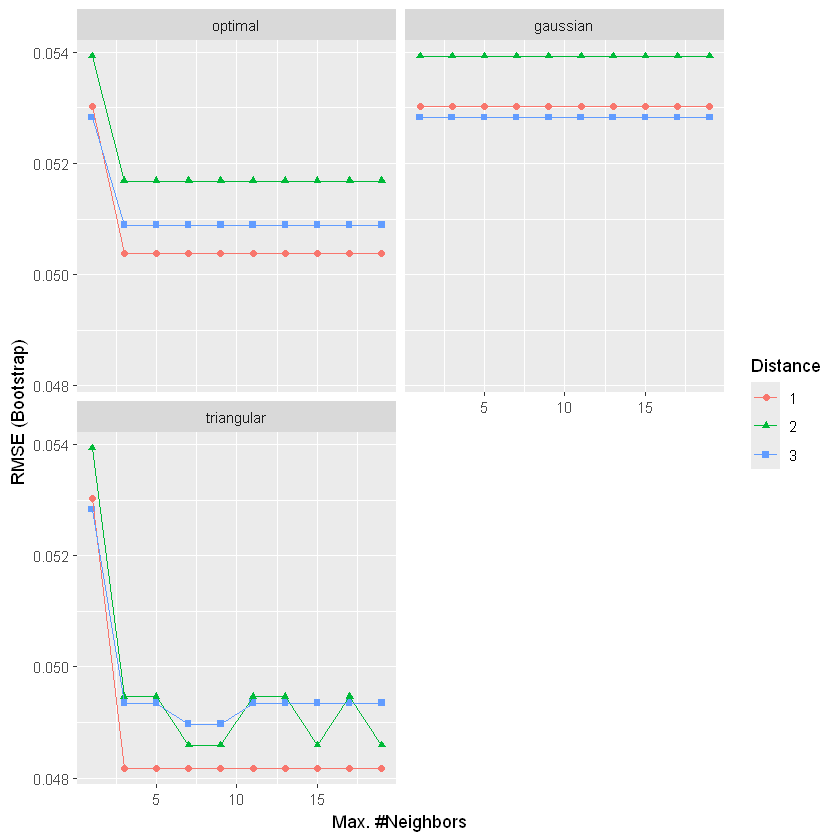

In [25]:
# grafico de los resultados
ggplot(knn_fit) +
  facet_wrap(~ kernel, ncol = 2)

Visualizar los resultados del ajuste del modelo permite:

- **Identificación de Hiperparámetros Óptimos**: Facilita la identificación de la mejor combinación de hiperparámetros que minimiza el RMSE.
- **Comparación de Desempeño**: Permite comparar el desempeño de diferentes tipos de kernel y métricas de distancia, ayudando a entender cuál combinación es más efectiva.
- **Información para Toma de Decisiones**: Proporciona información visual que puede ser utilizada para tomar decisiones informadas sobre qué hiperparámetros usar en el modelo final.

El gráfico indica que el uso de la distancia Manhattan (1) y el kernel triangular, con un número de vecinos entre 3 a 19, proporciona los mejores resultados en términos de RMSE. Esto valida los resultados numéricos obtenidos anteriormente y proporciona una representación visual clara del rendimiento del modelo.

Por otro lado el gráfico de resultados muestra que tanto un k-NN con 3 vecinos como uno con 19 vecinos producen RMSE similares, cuando la distancia es Manhattan y el kernel triangular. La diferencia en RMSE es mínima, por lo que es importante considerar otros factores al decidir entre estos dos valores de k.

Comparación entre k = 3 y k = 19

1. **k = 3**:
   - **Ventajas**:
     - **Menor Complejidad Computacional**: Utilizar 3 vecinos requiere menos cálculos de distancia y menos tiempo de predicción.
     - **Menor Riesgo de Sobreajuste**: Un valor de k bajo puede capturar las peculiaridades locales de los datos, pero aún mantiene una capacidad de generalización razonable.
   - **Desventajas**:
     - **Sensibilidad al Ruido**: Con un valor de k bajo, el modelo es más sensible al ruido y a las anomalías en los datos, lo que puede afectar la precisión de las predicciones en ciertos casos.

2. **k = 19**:
   - **Ventajas**:
     - **Mayor Robustez**: Utilizar más vecinos puede proporcionar predicciones más robustas y menos sensibles a las fluctuaciones y ruido en los datos, ya que se promedian más puntos.
     - **Reducción de Variabilidad**: Un valor de k más alto reduce la variabilidad de las predicciones y puede mejorar la estabilidad del modelo.
   - **Desventajas**:
     - **Mayor Complejidad Computacional**: Requiere más cálculos de distancia, lo que aumenta el tiempo de predicción y la carga computacional, especialmente con grandes conjuntos de datos.
     - **Riesgo de Subajuste**: Un valor de k muy alto puede llevar a subajuste, donde el modelo es demasiado general y no captura las relaciones locales en los datos.

Consideraciones Prácticas

- **Tamaño del Conjunto de Datos**: Con un conjunto de datos más grande, utilizar un k más alto como 19 puede ser más beneficioso para obtener predicciones robustas. En conjuntos de datos más pequeños, un valor más bajo como 3 puede ser más adecuado.
- **Distribución de los Datos**: Si los datos tienen muchas anomalías o ruido, un k más alto puede ser preferible para suavizar estos efectos. En casos donde los datos son limpios y consistentes, un k más bajo puede capturar mejor las relaciones locales.
- **Velocidad de Predicción**: Si la velocidad de predicción es crucial, un k más bajo será más rápido. Para aplicaciones en tiempo real, la diferencia en tiempo de computación entre k = 3 y k = 19 puede ser significativa.

La elección entre k = 3 y k = 19 depende entonces, de un balance entre robustez y sensibilidad, complejidad computacional y riesgo de sobreajuste o subajuste. Dado que la diferencia en RMSE es mínima, se puede considerar:

- **Para Mayor Robustez y Menos Sensibilidad al Ruido**: Utilizar k = 19.
- **Para Menor Complejidad Computacional y Mayor Sensibilidad a Relaciones Locales**: Utilizar k = 3.

En contextos donde se requiere una alta precisión y estabilidad en las predicciones, k = 19 puede ser la mejor opción. Para aplicaciones donde la velocidad y la simplicidad son más importantes, k = 3 podría ser preferible. Por ende, bajo este analisis la mejor opción será k = 19.

En la siguiente celda se aplica el modelo k-NN de regresión utilizando k = 19 vecinos, el método de kernel triangular y la distancia Manhattan (p = 1). Este ajuste se realiza para verificar si se obtiene un rendimiento óptimo del modelo, basado en los resultados anteriores.

In [32]:
set.seed(12345)
# Realizo la predicción con el modelo knn de regresión, con k=19
# y con el método de kernel triangular, distancia Manhattan p = 1
knn <- kknn(SalePrice ~ ., entrenamiento, prueba, kernel = "triangular",
            distance = 1, k = 19)
knn_pred <- knn$fitted.values
head(knn_pred)

[1] 0.04300163 0.31924285 0.02793283 0.10223801 0.48525172 0.16024872

Paso a Paso del Proceso

1. Configuración de la Semilla:

- `set.seed(12345)`: Establece una semilla para garantizar la reproducibilidad de los resultados.

2. Aplicación del Modelo k-NN con kknn:

- `knn <- kknn(SalePrice ~ ., entrenamiento, prueba, kernel = "triangular", distance = 1, k = 19)`:
- Utiliza la función kknn para crear un modelo k-NN de regresión.
- `SalePrice ~ .`: Indica que SalePrice es la variable objetivo y todas las demás columnas del conjunto de datos se utilizan como predictores.
- `kernel = "triangular"`: Especifica el uso del kernel triangular.
- `distance = 1`: Especifica el uso de la distancia Manhattan.
- `k = 19`: Indica que se utilizarán los 19 vecinos más cercanos para hacer las predicciones.

3. Obtención de las Predicciones:

- `knn_pred <- knn$fitted.values`: Extrae los valores predichos del modelo k-NN.
- `head(knn_pred)`: Muestra las primeras seis predicciones obtenidas por el modelo k-NN.

Este enfoque permitirá verificar si el uso de k = 19, distancia = 1 (manhattan) y kernel triangular proporcionan una mejora significativa en el rendimiento del modelo en comparación con los otros modelos considerando las métricas de evaluación y la robustez de las predicciones.

En la próxima celda se desnormalizan las predicciones obtenidas del modelo k-NN (con k = 19, kernel triangular, y distancia Manhattan) para devolver los valores a su escala original de SalePrice.

In [33]:
#Desnormalizo las predicciones para devolverlas a la escala original
knn_pred <- desnormalizar(knn_pred, min_vals["SalePrice"],
                          max_vals["SalePrice"])
head(knn_pred)

[1]  56527.07 209315.26  48192.56  89290.53 301134.27 121376.09

Los valores ahora están en la escala original de SalePrice, lo que permite una interpretación directa y una comparación con los valores reales en el conjunto de prueba.

La desnormalización de las predicciones es esencial para:

- Interpretación: Permitir la interpretación de las predicciones en el contexto original de los datos.
- Comparación: Facilitar la comparación directa entre las predicciones y los valores reales de SalePrice.

En la siguiente celda se desnormalizan los valores de SalePrice en el conjunto de prueba. Esto permite comparar las predicciones desnormalizadas con los valores reales de SalePrice en su escala original.

In [36]:
#desnormalizo los valores de SalePrice en el conjunto de prueba
precio_prueba <- desnormalizar(prueba$SalePrice, min_vals["SalePrice"],
                               max_vals["SalePrice"])
head(precio_prueba)

[1]  48672 200884  38053  92035 292035 138053

Estos valores están ahora en la escala original de SalePrice, lo que facilita la interpretación y comparación con las predicciones del modelo.

Desnormalizar SalePrice en el conjunto de prueba es crucial para:

- Comparabilidad: Permitir la comparación directa entre las predicciones desnormalizadas y los valores reales de SalePrice.
- Evaluación del Modelo: Facilitar la evaluación del rendimiento del modelo utilizando métricas.

In [35]:
#Veo las metricas de evaluacion
metrics(precio_prueba, knn_pred)

cor  = 0.9723958 
MAE  = 16558.37 
RMSE = 24760.22

Comparación de Resultados de k-NN Usando Diferentes Configuraciones y Paquetes

Resultados con `knnreg` (k = 1)

- **Correlación (cor)**: 0.9615033
- **MAE (Mean Absolute Error)**: 18413.52
- **RMSE (Root Mean Squared Error)**: 29335.16

Resultados con `kknn` sin Optimización (k = 1, distance = 2, kernel = optimal)

- **Correlación (cor)**: 0.962854
- **MAE (Mean Absolute Error)**: 17643.97
- **RMSE (Root Mean Squared Error)**: 28791.39

Resultados con `kknn` Optimizado (k = 19, distance = 1, kernel = triangular)

- **Correlación (cor)**: 0.9723958
- **MAE (Mean Absolute Error)**: 16558.37
- **RMSE (Root Mean Squared Error)**: 24760.22

Análisis de los Resultados

Correlación

- **`knnreg` (k = 1)**: 0.9615033
- **`kknn` sin optimización**: 0.962854
- **`kknn` optimizado**: 0.9723958
- **Interpretación**: La correlación mejora ligeramente con el uso de `kknn` en comparación con `knnreg`. La mayor mejora se observa con la versión optimizada de `kknn`, indicando una mejor alineación entre las predicciones y los valores reales.

MAE (Mean Absolute Error)

- **`knnreg` (k = 1)**: 18413.52
- **`kknn` sin optimización**: 17643.97
- **`kknn` optimizado**: 16558.37
- **Interpretación**: El MAE disminuye significativamente al pasar de `knnreg` a `kknn`, y aún más con la versión optimizada de `kknn`. Un MAE más bajo indica que las predicciones están, en promedio, más cerca de los valores reales, lo que sugiere una mejora en la precisión del modelo.

RMSE (Root Mean Squared Error)

- **`knnreg` (k = 1)**: 29335.16
- **`kknn` sin optimización**: 28791.39
- **`kknn` optimizado**: 24760.22
- **Interpretación**: El RMSE muestra una reducción significativa al pasar de `knnreg` a `kknn`, y aún más con la versión optimizada de `kknn`. Un RMSE más bajo indica una menor desviación cuadrática media entre las predicciones y los valores reales, lo que refleja una mejor capacidad del modelo para hacer predicciones precisas.

Ventajas de Usar `kknn` con Hiperparámetros Optimizados

1. **Mayor Precisión**:
   - La optimización de los hiperparámetros en `kknn` ha resultado en mejoras significativas en las métricas de evaluación, particularmente en RMSE y MAE, que son indicadores clave de la precisión del modelo.
   - La correlación más alta también sugiere que el modelo optimizado captura mejor la relación entre las variables predictoras y la variable objetivo.

2. **Flexibilidad y Configurabilidad**:
   - `kknn` permite ajustar no solo el número de vecinos (k), sino también la métrica de distancia y el tipo de kernel, proporcionando una mayor flexibilidad para adaptar el modelo a los datos específicos.
   - La capacidad de optimizar estos parámetros ayuda a mejorar significativamente el rendimiento del modelo en comparación con el uso de configuraciones predeterminadas.

Conclusión

El uso del paquete `kknn` con una cuadrícula de hiperparámetros y el método de bootstrap ha permitido encontrar una combinación óptima de parámetros que mejora significativamente las métricas de rendimiento del modelo k-NN. En particular, utilizar k = 19, distancia Manhattan, y kernel triangular ha resultado en el mejor rendimiento, minimizando el RMSE y mejorando la precisión de las predicciones.